In [19]:
import cv2
from matplotlib import pyplot
import numpy

# Ustawienie rozmarów wyświetlanych obrazów
pyplot.rcParams["figure.figsize"] = (18, 10)

In [20]:
#
# Wczytanie obrazów źródłowych
#
# źródło grafiki colors.jpg: https://unsplash.com/photos/gT5kuls6Y6Q
# źródło grafiki gacław-na-kuchni.jpg: własne
#

image_from_file = cv2.imread('images/kot.jpg')
image_gray = cv2.cvtColor(image_from_file, cv2.COLOR_BGR2GRAY)
image_color = cv2.cvtColor(image_from_file, cv2.COLOR_BGR2RGB)
print('Rozmiar obrazka: ', image_from_file.shape)

Rozmiar obrazka:  (768, 1024, 3)


# Zadanie 1

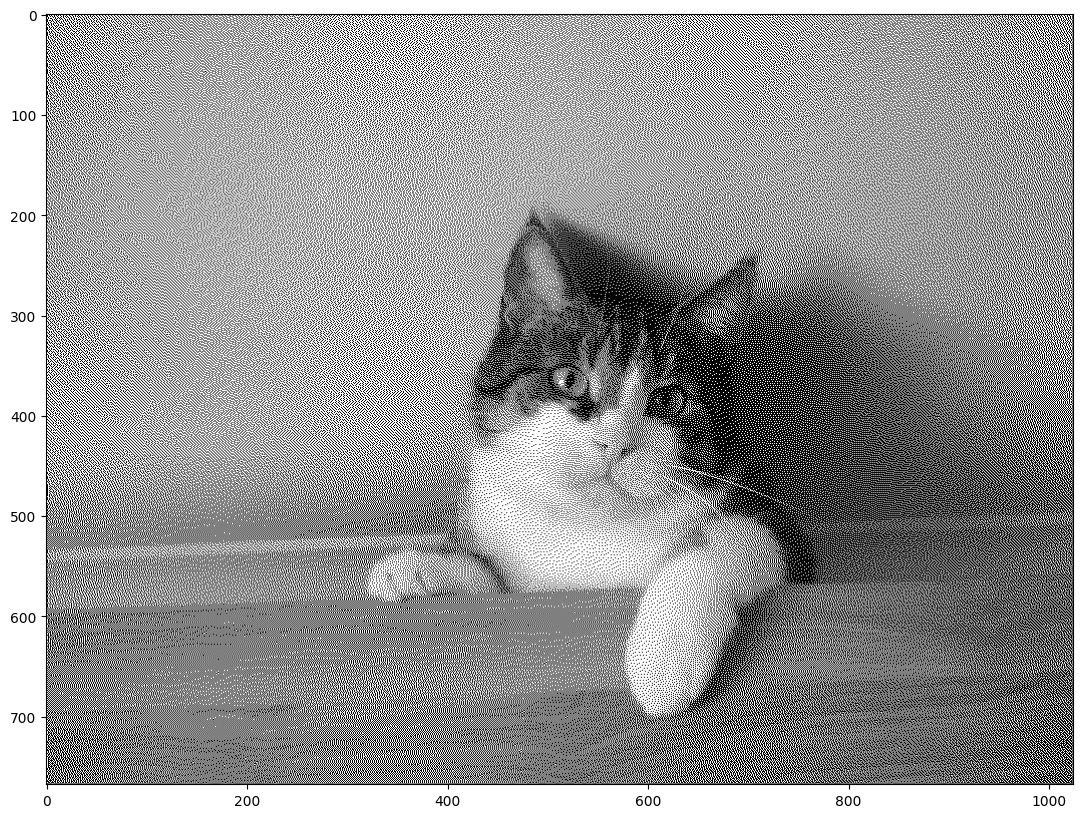

In [21]:
output = numpy.copy(image_gray)
output = output.astype(dtype=int)

#
# Algorytm
#

def find_closest_grey_color(pixel: int) -> int:
    return round(pixel / 255) * 255


for y in range(output.shape[0] - 1):
    for x in range(output.shape[1] - 1):
        oldpixel = output[y][x]
        newpixel = find_closest_grey_color(oldpixel)
        output[y][x] = newpixel
        quant_error = oldpixel - newpixel
        
        output[y][x + 1] = output[y][x + 1] + quant_error * 7 / 16
        output[y + 1][x - 1] = output[y + 1][x - 1] + quant_error * 3 / 16
        output[y + 1][x] = output[y + 1][x] + quant_error * 5 / 16
        output[y + 1][x + 1] = output[y + 1][x + 1] + quant_error * 1 / 16
        
numpy.clip(output,0,255)
output = output.astype(dtype=numpy.uint8)


#
# Wyświetlenie
#
pyplot.imshow(output, cmap='gray')

Text(0, 0.5, 'Liczba pikseli obrazu []')

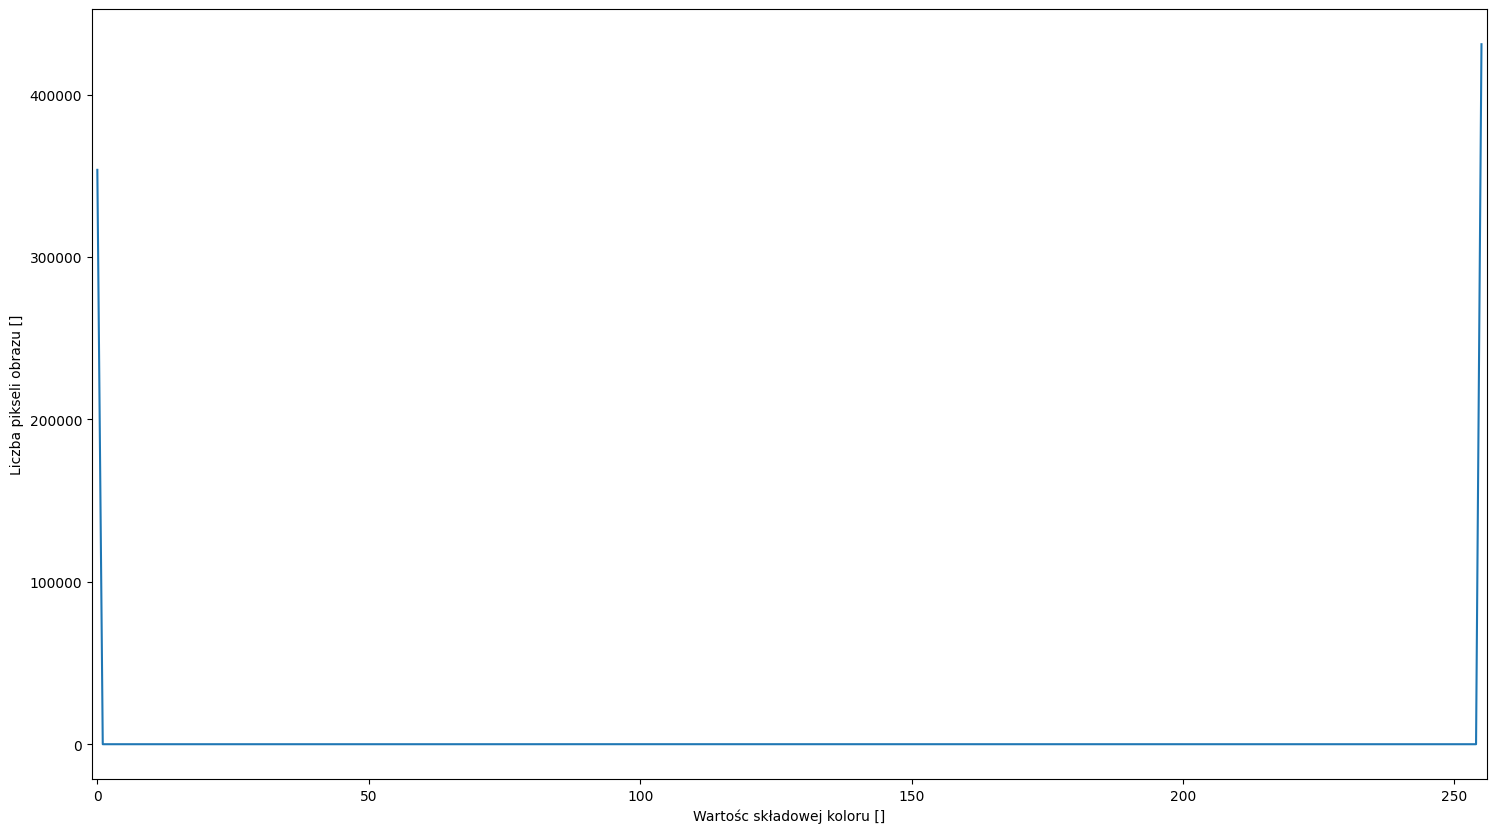

In [22]:
#
# Histogram
#
histr = cv2.calcHist([output], [0], None, [256], [0, 256])
pyplot.plot(histr)
pyplot.xlim([-1, 256])
pyplot.xlabel('Wartośc składowej koloru []')
pyplot.ylabel('Liczba pikseli obrazu []')

# Zadanie 2

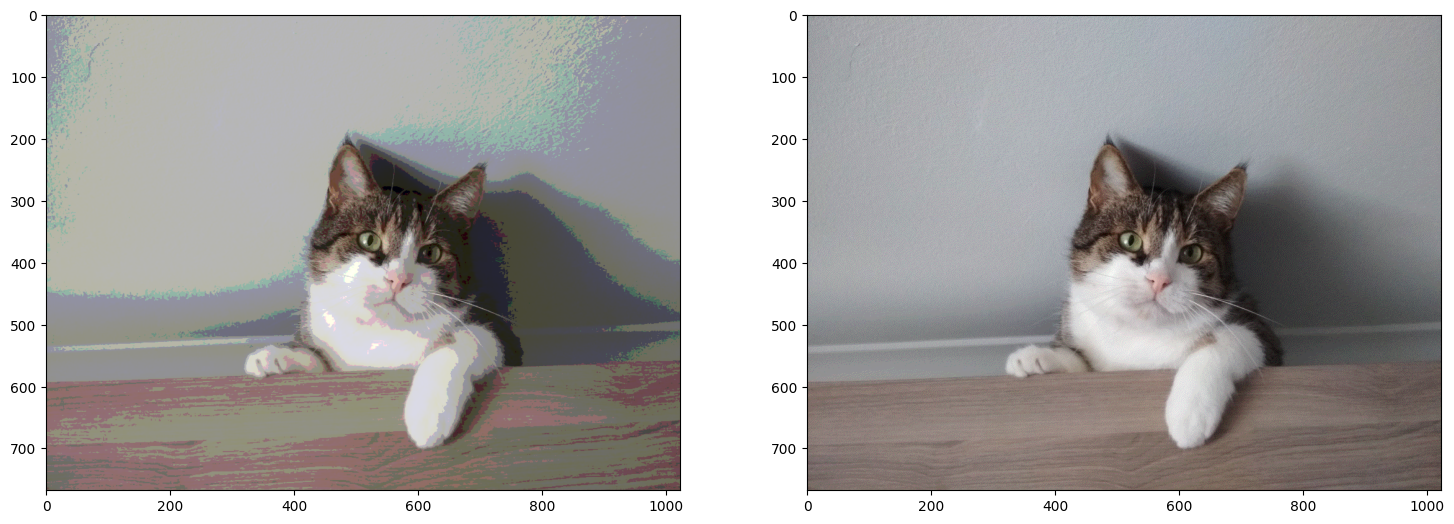

In [23]:
output = numpy.copy(image_color)
output = output.astype(dtype=int)
reduced = numpy.copy(image_color)

#
# Algorytm
#
tones = 8

def find_closest_palette_color(pix, k = 2):
    return round((k - 1) * pix / 255) * 255/(k - 1)

def normalize_surrounding(image, old_pixel, new_pixel):
    for i in range(2):
        quant_error = old_pixel[i] - new_pixel[i]
        
        image[y][x + 1][i] = image[y][x + 1][i] + quant_error * 7 / 16
        image[y + 1][x - 1][i] = image[y + 1][x - 1][i] + quant_error * 3 / 16
        image[y + 1][x][i] = image[y + 1][x][i] + quant_error * 5 / 16
        image[y + 1][x + 1][i] = image[y + 1][x + 1][i] + quant_error * 1 / 16


for y in range(output.shape[0] - 1):
    for x in range(output.shape[1] - 1):
        old_pixel = [output[y][x][0], output[y][x][1], output[y][x][2]]
        new_pixel = [0, 0, 0]
        
        new_pixel = [find_closest_palette_color(old_pixel[i], tones) for i in range(2)]
        for i in range(2): reduced[y][x][i] = find_closest_palette_color(reduced[y][x][i], tones) 
        for i in range(2): output[y][x][i] = new_pixel[i]
            
        normalize_surrounding(output, old_pixel, new_pixel)
        
numpy.clip(output,0,255)
numpy.clip(reduced,0,255)
output = output.astype(dtype=numpy.uint8)

#
# Wyświetlenie
#
fig, ax = pyplot.subplots(1, 2)
ax[0].imshow(reduced)
ax[1].imshow(output)

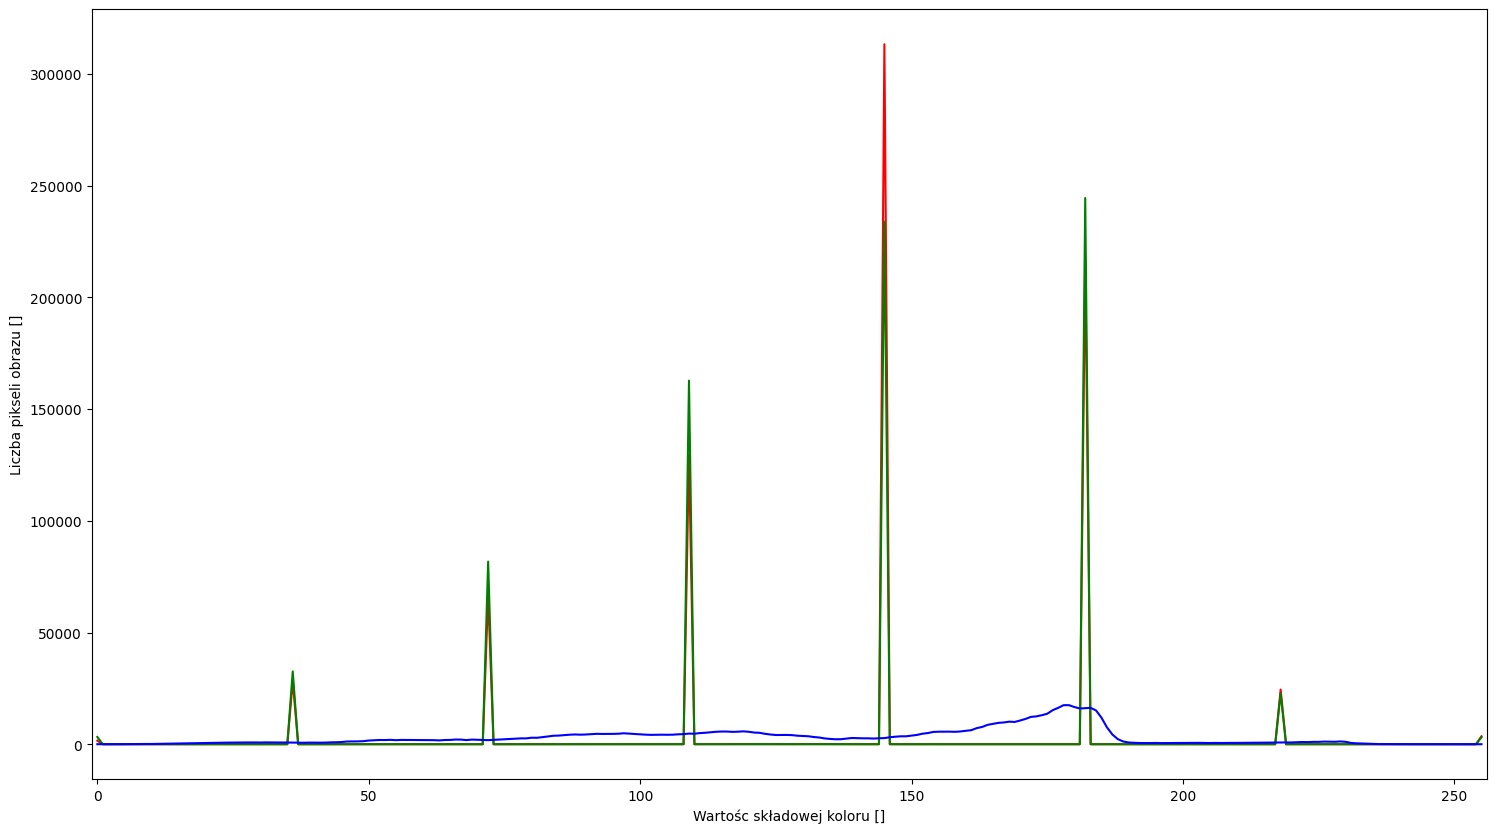

In [24]:
#
# Histogram
#
color = ('r', 'g', 'b')

for i, col in enumerate(color):
    histr = cv2.calcHist([output], [i], None, [256], [0, 256])
    pyplot.plot(histr, color=col)
    pyplot.xlim([-1, 256])
    pyplot.xlabel('Wartośc składowej koloru []')
    pyplot.ylabel('Liczba pikseli obrazu []')

# Zadanie 3

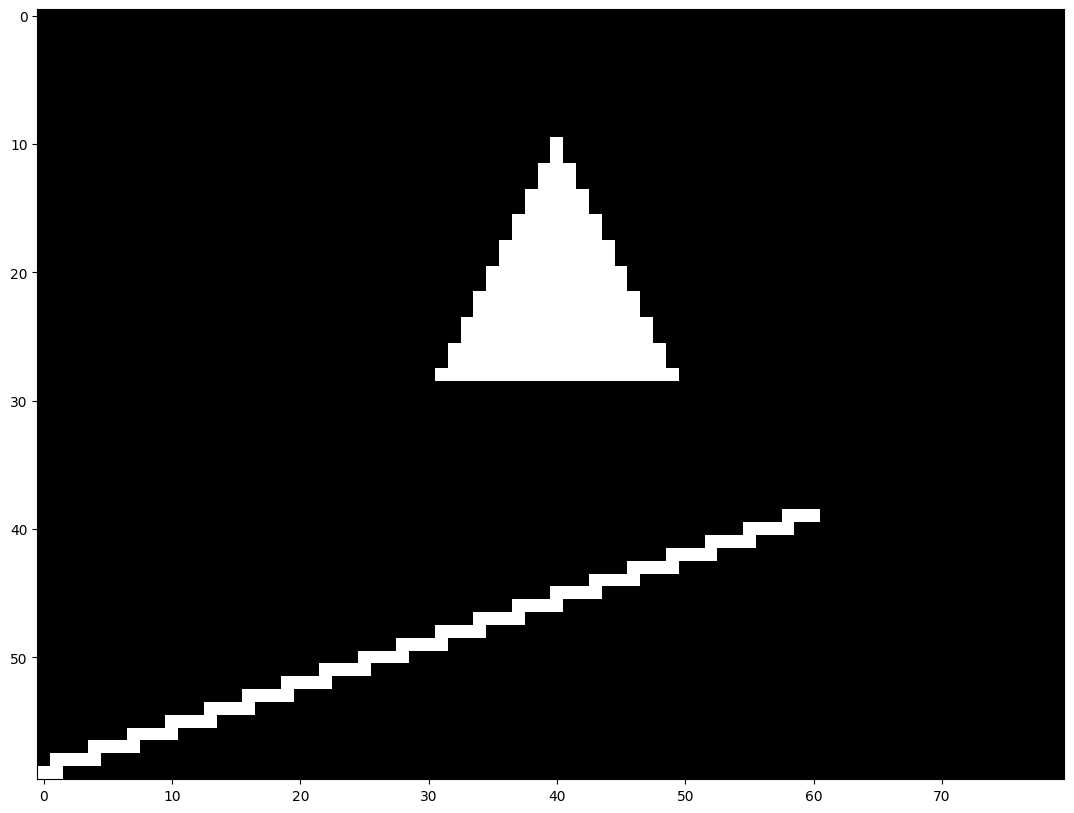

In [44]:
#
# Przygotowanie płótna
#
width = 80
height = 60
image = numpy.zeros((height, width, 3), dtype=numpy.uint8)


#
# Funkcja rysująca punkt
#
# NOTE(sdatko): punkt 0,0 to lewy dolny róg obrazu
#
def draw_point(image, x, y, color=(255, 255, 255)):
    image[image.shape[0] - 1 - y, x, :] = color


#
# Funkcja rysująca linię
#
def draw_line(image, x1, y1, x2, y2):
    delta_x = abs(x2 - x1)
    delta_y = abs(y2 - y1)

    direction_x = numpy.sign(x2 - x1)
    direction_y = numpy.sign(y2 - y1)

    error = 2 * delta_y - delta_x if delta_x > delta_y else 2 * delta_x - delta_y

    coords = [x1, y1]
    draw_point(image, x1, y1)

    while coords[0] != x2 or coords[1] != y2:

        if delta_x > delta_y:
            coords[0] += direction_x
            error += 2 * delta_y
        else:
            coords[1] += direction_y
            error += 2 * delta_x

        draw_point(image, coords[0], coords[1])

        if error >= 0 and delta_x > delta_y:
            coords[1] += direction_y
            error -= 2 * delta_x
        elif error >= 0 and delta_x <= delta_y:
            coords[0] += direction_x
            error -= 2 * delta_y

        draw_point(image, coords[0], coords[1])




#
# Funkcja rysująca trójkąt
#
class vertex:
    x = 0
    y = 0
    
    def __init__(self, a, b):
        self.x = a
        self.y = b


def calc_area(a, b, c):
    return (c.x - a.x) * (b.y - a.y) - (c.y - a.y) * (b.x - a.x)


def draw_triangle(image, a, b, c):
    low_x = min(a.x, b.x, c.x)
    high_x = max(a.x, b.x, c.x)

    low_y = min(a.y, b.y, c.y)
    high_y = max(a.y, b.y, c.y)

    for y in range(low_y, high_y + 1):
        for x in range(low_x, high_x + 1):
            ar1 = calc_area(a, b, vertex(x, y))
            ar2 = calc_area(b, c, vertex(x, y))
            ar3 = calc_area(c, a, vertex(x, y))

            if numpy.sign(ar1) == numpy.sign(ar2) and numpy.sign(ar2) == numpy.sign(ar3):
                draw_point(image, x, y)
    


#
# Rysowanie
#
draw_line(image, 0, 0, 60, 20)
ver0 = vertex(30, 30)
ver1 = vertex(50, 30)
ver2 = vertex(40, 50)
draw_triangle(image, ver0, ver1, ver2)

#
# Wyświetlenie
#
pyplot.imshow(image)

# Zadanie 4

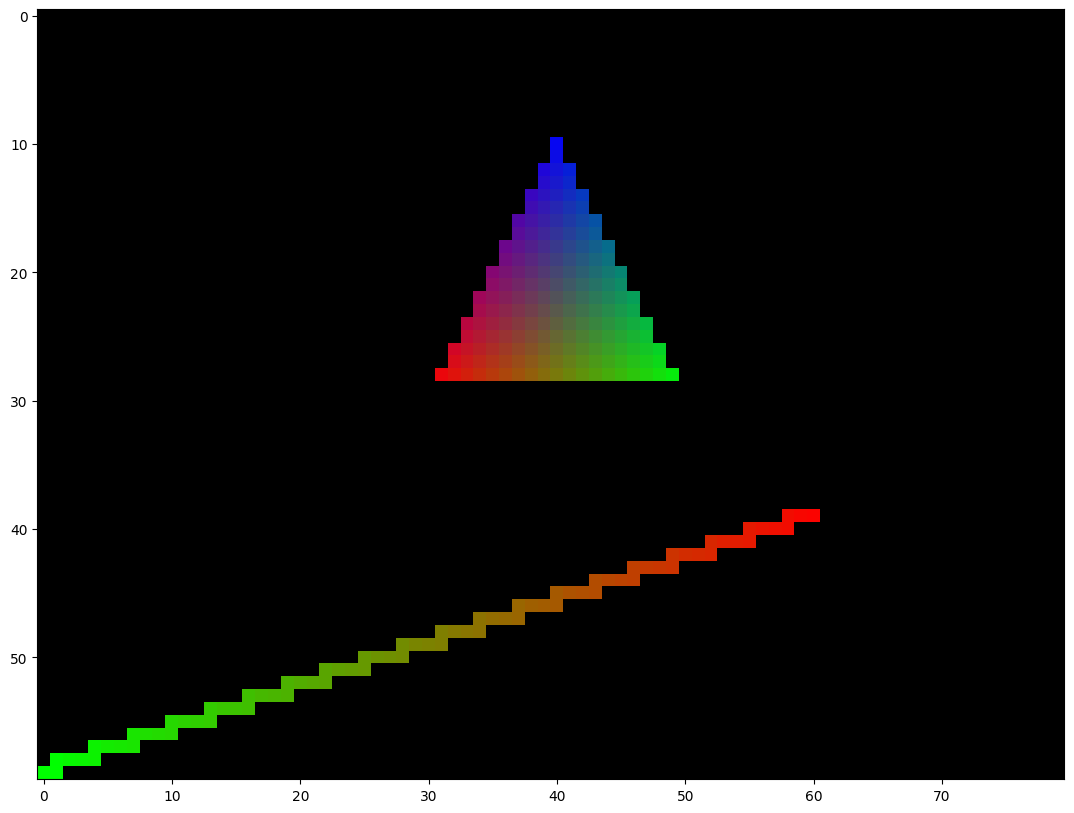

In [40]:
#
# Przygotowanie płótna
#
width = 80
height = 60
image = numpy.zeros((height, width, 3), dtype=numpy.uint8)


#
# Funkcja rysująca punkt
#
# NOTE(sdatko): punkt 0,0 to lewy dolny róg obrazu
#
def draw_point(image, x, y, color=(255, 255, 255)):
    image[image.shape[0] - 1 - y, x, :] = color


#
# Funkcja rysująca linię
#
def draw_line(image, x1, y1, x2, y2, start_color=(255, 255, 255), end_color=(255, 255, 255)):
    delta_x = abs(x2 - x1)
    delta_y = abs(y2 - y1)

    direction_x = numpy.sign(x2 - x1)
    direction_y = numpy.sign(y2 - y1)

    error = 2 * delta_y - delta_x if delta_x > delta_y else 2 * delta_x - delta_y

    coords = [x1, y1]
    draw_point(image, x1, y1, end_color)

    curr_color = start_color

    while coords[0] != x2 or coords[1] != y2:
        t = (abs(coords[0] - x2) + abs(coords[1] - y2)) / (delta_x + delta_y)
        curr_color = [start_color[i] + t * (end_color[i] - start_color[i]) for i in range(3)]

        if delta_x > delta_y:
            coords[0] += direction_x
            error += 2 * delta_y
        else:
            coords[1] += direction_y
            error += 2 * delta_x

        draw_point(image, coords[0], coords[1], curr_color)
        

        if error >= 0 and delta_x > delta_y:
            coords[1] += direction_y
            error -= 2 * delta_x
        elif error >= 0 and delta_x <= delta_y:
            coords[0] += direction_x
            error -= 2 * delta_y

        draw_point(image, coords[0], coords[1], curr_color)

        t = (abs(coords[0] - x2) + abs(coords[1] - y2)) / (delta_x + delta_y)
        curr_color = [start_color[i] + t * (end_color[i] - start_color[i]) for i in range(2)]




#
# Funkcja rysująca trójkąt
#
class vertex:
    def __init__(self, a, b, color = (255, 255, 255)):
        self.x = a
        self.y = b
        self.color = color


def calc_area(a, b, c):
    return (c.x - a.x) * (b.y - a.y) - (c.y - a.y) * (b.x - a.x)


def draw_triangle(image, a, b, c):
    low_x = min(a.x, b.x, c.x)
    high_x = max(a.x, b.x, c.x)

    low_y = min(a.y, b.y, c.y)
    high_y = max(a.y, b.y, c.y)

    for y in range(low_y, high_y + 1):
        for x in range(low_x, high_x + 1):
            ar1 = calc_area(a, b, vertex(x, y))
            ar2 = calc_area(b, c, vertex(x, y))
            ar3 = calc_area(c, a, vertex(x, y))
            ar = calc_area(a, b, c)

            if numpy.sign(ar1) == numpy.sign(ar2) and numpy.sign(ar2) == numpy.sign(ar3):
                color = [ar1/ar * a.color[i] + ar2/ar * b.color[i] + ar3/ar * c.color[i] for i in range(3)]
                draw_point(image, x, y, color)
    


#
# Rysowanie
#
draw_line(image, 0, 0, 60, 20, [255, 0, 0], [0, 255, 0])

ver0 = vertex(30, 30, [0, 0, 255])
ver1 = vertex(50, 30, [255, 0, 0])
ver2 = vertex(40, 50, [0, 255, 0])
draw_triangle(image, ver0, ver1, ver2)

#
# Wyświetlenie
#
pyplot.imshow(image)

# Zadanie 5

In [ ]:
#
# Przygotowanie płótna
#
width = 80
height = 60
image = numpy.zeros((height, width, 3), dtype=numpy.uint8)


#
# Funkcja rysująca punkt
#
# NOTE(sdatko): punkt 0,0 to lewy dolny róg obrazu
#
def draw_point(image, x, y, color=(255, 255, 255)):
    image[image.shape[0] - 1 - y, x, :] = color


#
# Funkcja rysująca linię
#
def draw_line(image, x1, y1, x2, y2):
    pass  # TODO: implement


#
# Funkcja rysująca trójkąt
#
def draw_triangle(image, a, b, c):
    pass  # TODO: implement


#
# Rysowanie
#
pass  # TODO: implement

#
# Wyświetlenie
#
pyplot.imshow(image)